# <span style="color:darkblue"> Laboratorio di Simulazione Numerica </span>
#### <span style="color:darkred">  Andrea Sala - Settembre 2020</span>
# <span style="color:darkgreen">  Esercitazione 7</span>

## Esercizio 7.1

Use the Monte Carlo NVT code we have provided to print out instantaneous values of potential energy per particle, $U/N$, and pressure, $P$, along **equilibrated** Monte Carlo simulations (of  $M=10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase:  $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase:       $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)



1. <span style="color:red">Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ and $P$ to obtain the Monte Carlo correlation time</span> via a fit with an exponential function. This will suggest you how large should be the blocks in your simulations.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ and $P$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. <span style="color:red">Make pictures of these statistical uncertainties as a function of $L$.</span> What do you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?
    

Il codice simula un problema nell'ensemble canonico di `nparts`=108 particelle come nel caso dell'Esercitazione 4.
Il codice presenta molte similarità con quello della dinamica molecolare nel suo funzionamento (partenza da una configurazione fcc, dati da file di input, unità Lennard-Jones, ...) che non verranno quindi ripetute. La differenza è che qui non viene usato un algoritmo deterministico come il Verlet, bensì vengono usati degli algoritmi Monte Carlo per far evolvere il sistema. L'algoritmo usato è il già noto Algoritmo di Metropolis, che propone delle mosse campionando il peso di Boltzmann ad ogni step temporale.
Per prima cosa è stato necessario regolare l'ampiezza del passo Metropolis per le diverse fasi in modo da avere un'accetazione vicina al 50%. I parametri ottimali sono 0.12 per la fase solida, 0.2 per la fase liquida e 6 per la fase gassosa. Ho interpretato la grossa differenza tra i primi due valori e l'ultimo con il fatto che in fase gassosa le particelle tendono ad occupare un volume maggiore a causa della minore attrazione reciproca, e dunque per campionare al meglio la distribuzione è necessario utilizzare un passo più ampio. Un'altro motivo è che lo stato gassoso è per definizione più disordinato e quindi logicamente andrà a "perdere memoria" più velocemente. Dopo aver scelto un adeguato passo Metropolis, ho proceduto ad equilibrare il sistema eseguendo una run senza salvare i valori e ripartendo in seguito copiando nel file `config.0` la configurazione finale della run precedente.
Inoltre, sono state aggiunte le *tail corrections* per compensare il *cutoff* del range del potenziale di attrazione. Queste correzioni, che non vengono riportate esplicitamente, sono state applicate sia al calcolo dell'energia potenziale che a quello della pressione.

Successivamente, ho calcolato la funzione di autocorrelazione tra valori istantanei (dunque non mediati) di energia per particella $\frac{U}{N}$ e $P$, entrambe fittate con un modello esponenziale. La funzione di autocorrelazione
$$ AC(t') = \frac{\left\langle m(t)m(t+t') \right\rangle - \left\langle m(t) \right\rangle\left\langle m(t+t') \right\rangle}{\sigma^2_m}$$
esprime quanto sono correlati due valori che distano $t'$ step Monte Carlo l'uno dall'altro. Dai grafici sottostanti si nota che la funzione di autocrrelazione tende a zero dopo circa 100 step Monte Carlo in tutti i casi. Il tempo di autocorrelazione "esatto "ricavato dal parametro di fit è stato stampato sotto. Questo procedimento dà un primo indizio su quanto dovrebbe essere spesso un blocco affinchè le misure nei diversi blocchi siano correlate solo superficialmente. <br/>
Per ottenere un'informazione più precisa, ho calcolato l'errore che blocchi di diversa lunghezza produrrebbero sulla simulazione utilizzando i valori istantanei delle grandezze fisiche (la cui stampa ho implementato con la funzione `InstantPrint()`). Di seguito vengono riportati i grafici ottenuti e le conclusioni che ne ho tratto sulla lugnhezza dei blocchi da prendere. Come immaginavo a casua della grande differenza tra i passi Metropolis, nella fase gassosa la funzione di autocorrelazione tende a zero molto più velocemente (passi ampi = misure scorrelate).

In [3]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import math
import scipy
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf

%config InlineBackend.figure_format = 'retina'

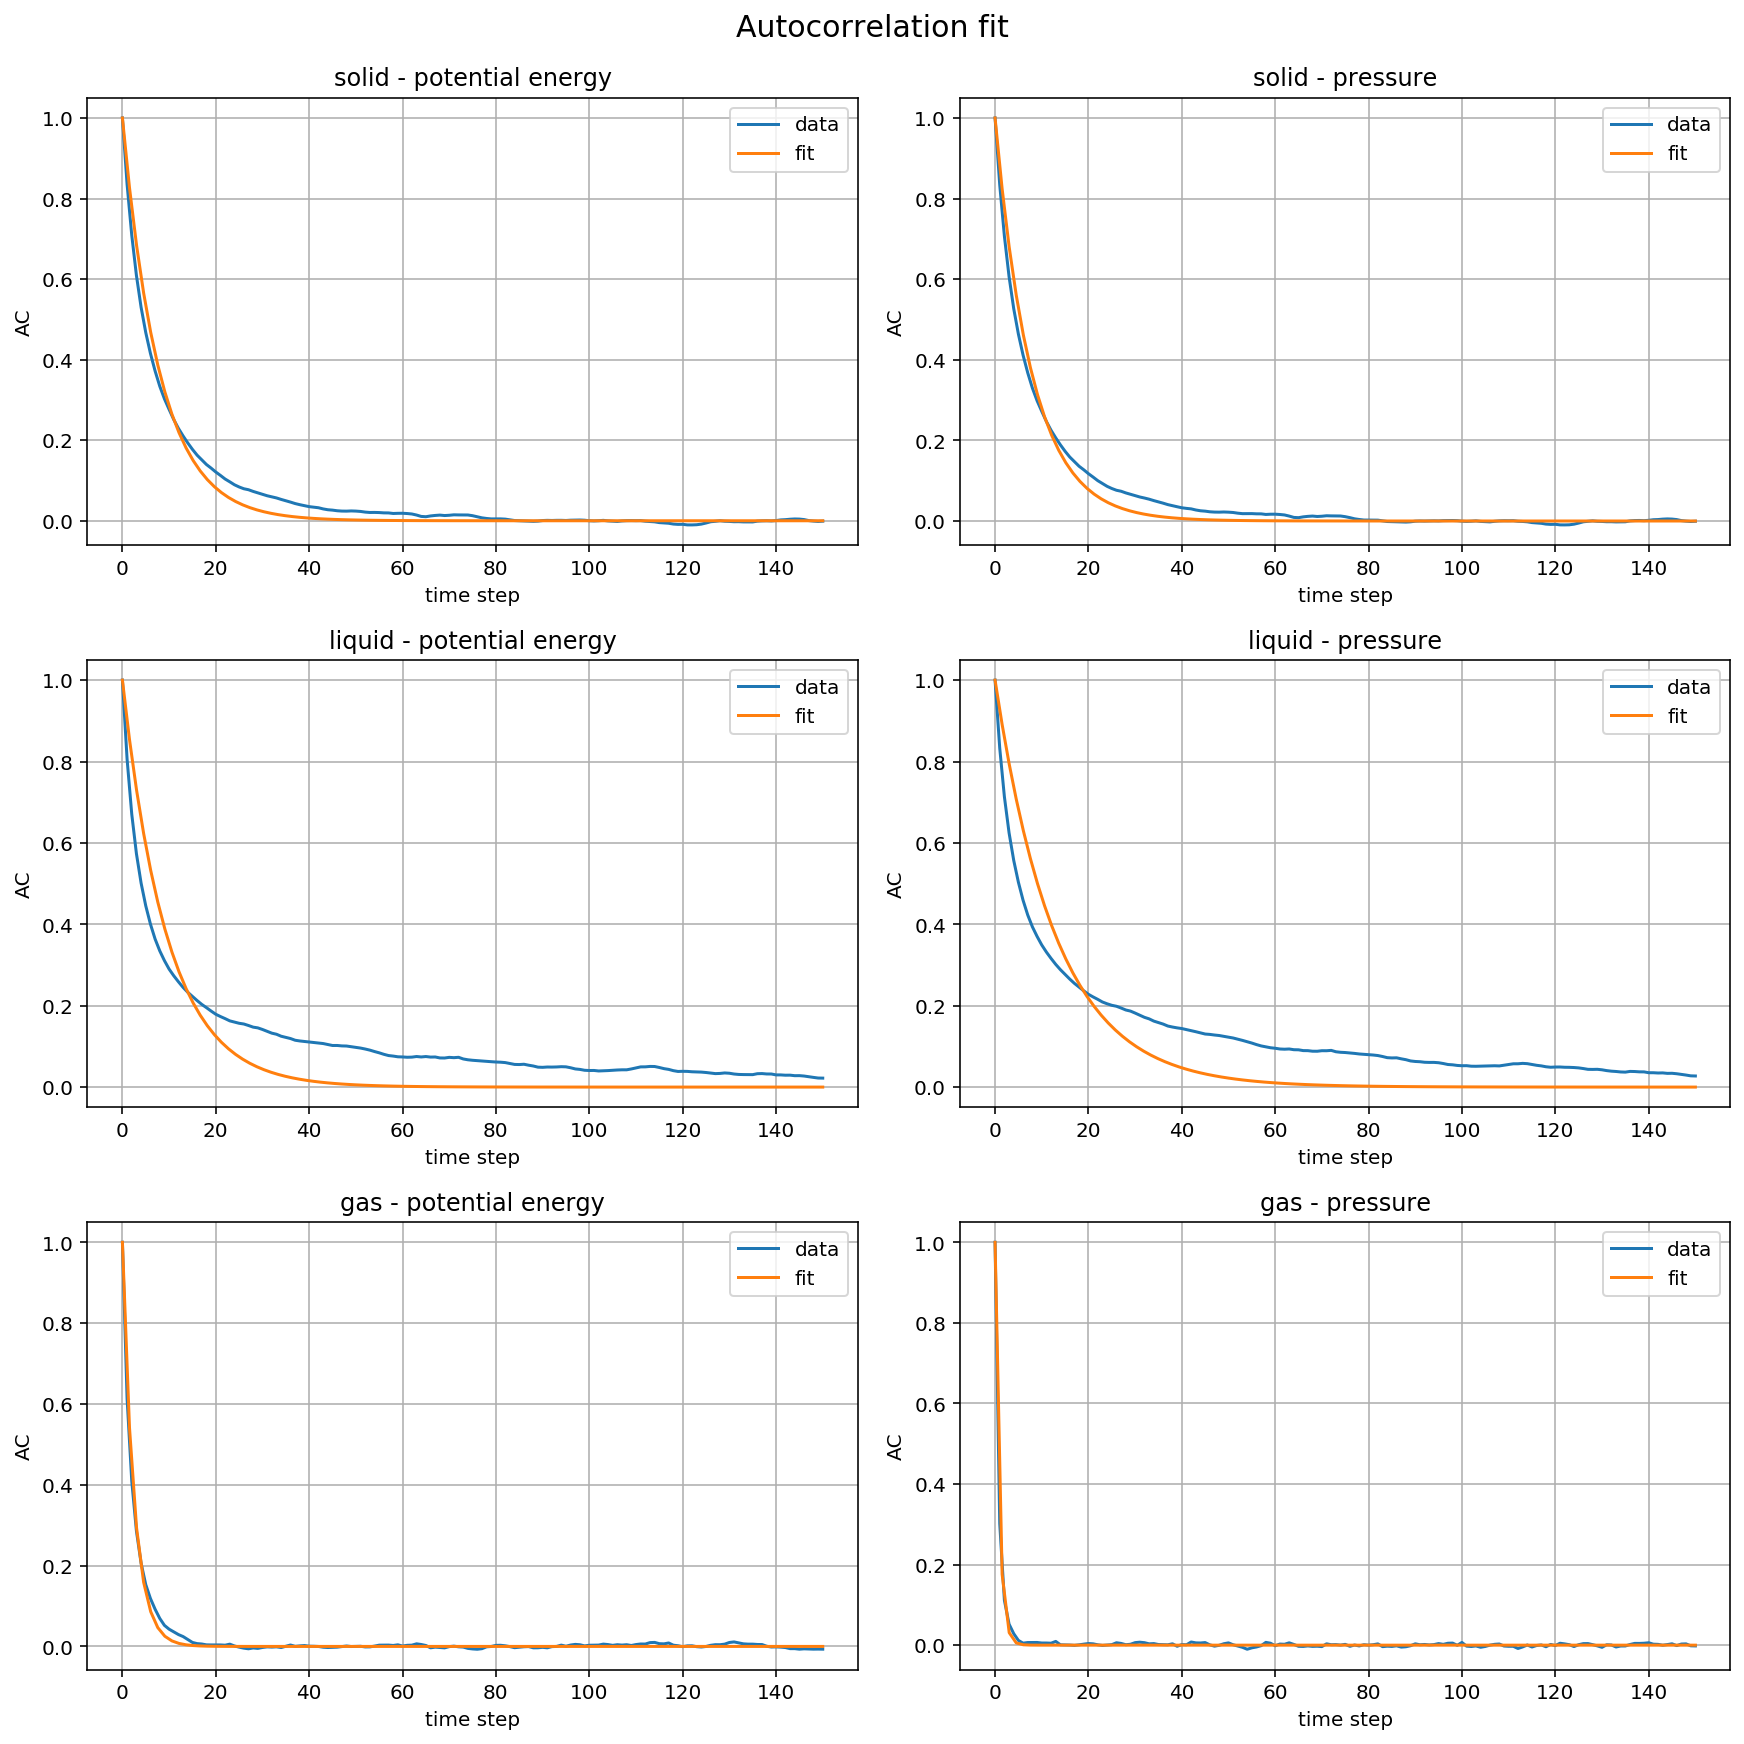

        ***AUTOCORRELATION TIME***
/                energy                  pressure
solid phase: = [7.97307925]        [7.83653381]
liquid phase: = [9.61147201]        [13.11454711]
gas phase: = [2.46978066]        [0.8719837]


In [4]:
phases = ['solid', 'liquid', 'gas']

fig, axs = plt.subplots(3,2, constrained_layout=True, figsize=(12,12))
fig.suptitle('Autocorrelation fit', fontsize=15)
maxlag = 150
exp_par = []

for index, phase in enumerate(phases):
    u, P = np.loadtxt( phase + '/' + phase +'_InstantValues.out', unpack=True) #CAMBIARE LA FASE!!!
    acorr_u = acf(u, nlags=maxlag, fft=True) #calculate autocorr
    acorr_P = acf(P, nlags=maxlag, fft=True)

    axs[index][0].plot(range(maxlag+1), acorr_u, label='data') #plot autocorrelation
    par_u, corr_u = scipy.optimize.curve_fit(lambda t,a: np.exp(-a*t),  range(maxlag+1),  acorr_u, p0=1) #fit autocorr
    x_pl = np.linspace(0,maxlag,100)
    axs[index][0].plot(x_pl, np.exp(-par_u*x_pl), label='fit')
    axs[index][0].set_title(phase +' - potential energy')

    axs[index][1].plot(range(maxlag+1), acorr_P, label='data') #plot autocorrelation
    par_P, corr_P = scipy.optimize.curve_fit(lambda t,a: np.exp(-a*t),  range(maxlag+1),  acorr_P, p0=1) #fit autocorr
    x_pl = np.linspace(0,maxlag,100)
    axs[index][1].plot(x_pl, np.exp(-par_P*x_pl), label='fit')
    axs[index][1].set_title(phase +' - pressure')
    
    exp_par.append([par_u, par_P]) # save fit parameters
    
for ax in axs.reshape(-1):
    ax.grid()
    ax.legend()
    ax.set_xlabel('time step')
    ax.set_ylabel('AC')
    
plt.show()

print('        ***AUTOCORRELATION TIME***')
print("/                energy                  pressure")
for (fit_u, fit_P), phase in zip(exp_par,phases):
    print('{0} phase: = {1}        {2}'.format(phase, 1/fit_u, 1/fit_P))

In [5]:
def Error(Phys, M, N):
    L=(int)(M/N)
    av=0.
    prog=0.
    prog2=0.
    err=0.
    
    for i in range(N):
        av = 0
        for j in range(L):
            k = j+i*L
            av += Phys[k]/L
        prog += av
        prog2 += (av)**2 

    err = ((prog2/(N)-prog*prog/(N*N))/(N-1))**0.5    
    
    return err   

In [6]:
N=100000
possible_block_size= np.array([50,100,200,500,1000,2000,5000,10000,15000,20000])

err_pot_s= np.zeros(len(possible_block_size))
err_pres_s= np.zeros(len(possible_block_size))
err_pot_l= np.zeros(len(possible_block_size))
err_pres_l= np.zeros(len(possible_block_size))
err_pot_g= np.zeros(len(possible_block_size))
err_pres_g= np.zeros(len(possible_block_size))

U_s, P_s= np.loadtxt('solid/solid_InstantValues.out', unpack=True)
U_l, P_l= np.loadtxt('liquid/liquid_InstantValues.out', unpack=True)
U_g, P_g= np.loadtxt('gas/gas_InstantValues.out', unpack=True)


L = np.zeros(len(possible_block_size))
i=0

for pbs in possible_block_size:
    
    err_pot_s[i]  = Error(U_s,N,pbs)
    err_pres_s[i] = Error(P_s,N,pbs)
    err_pot_l[i]  = Error(U_l,N,pbs)
    err_pres_l[i] = Error(P_l,N,pbs)
    err_pot_g[i]  = Error(U_g,N,pbs)
    err_pres_g[i] = Error(P_g,N,pbs)
    
    L[i]=(int)(N/pbs)
    i=i+1

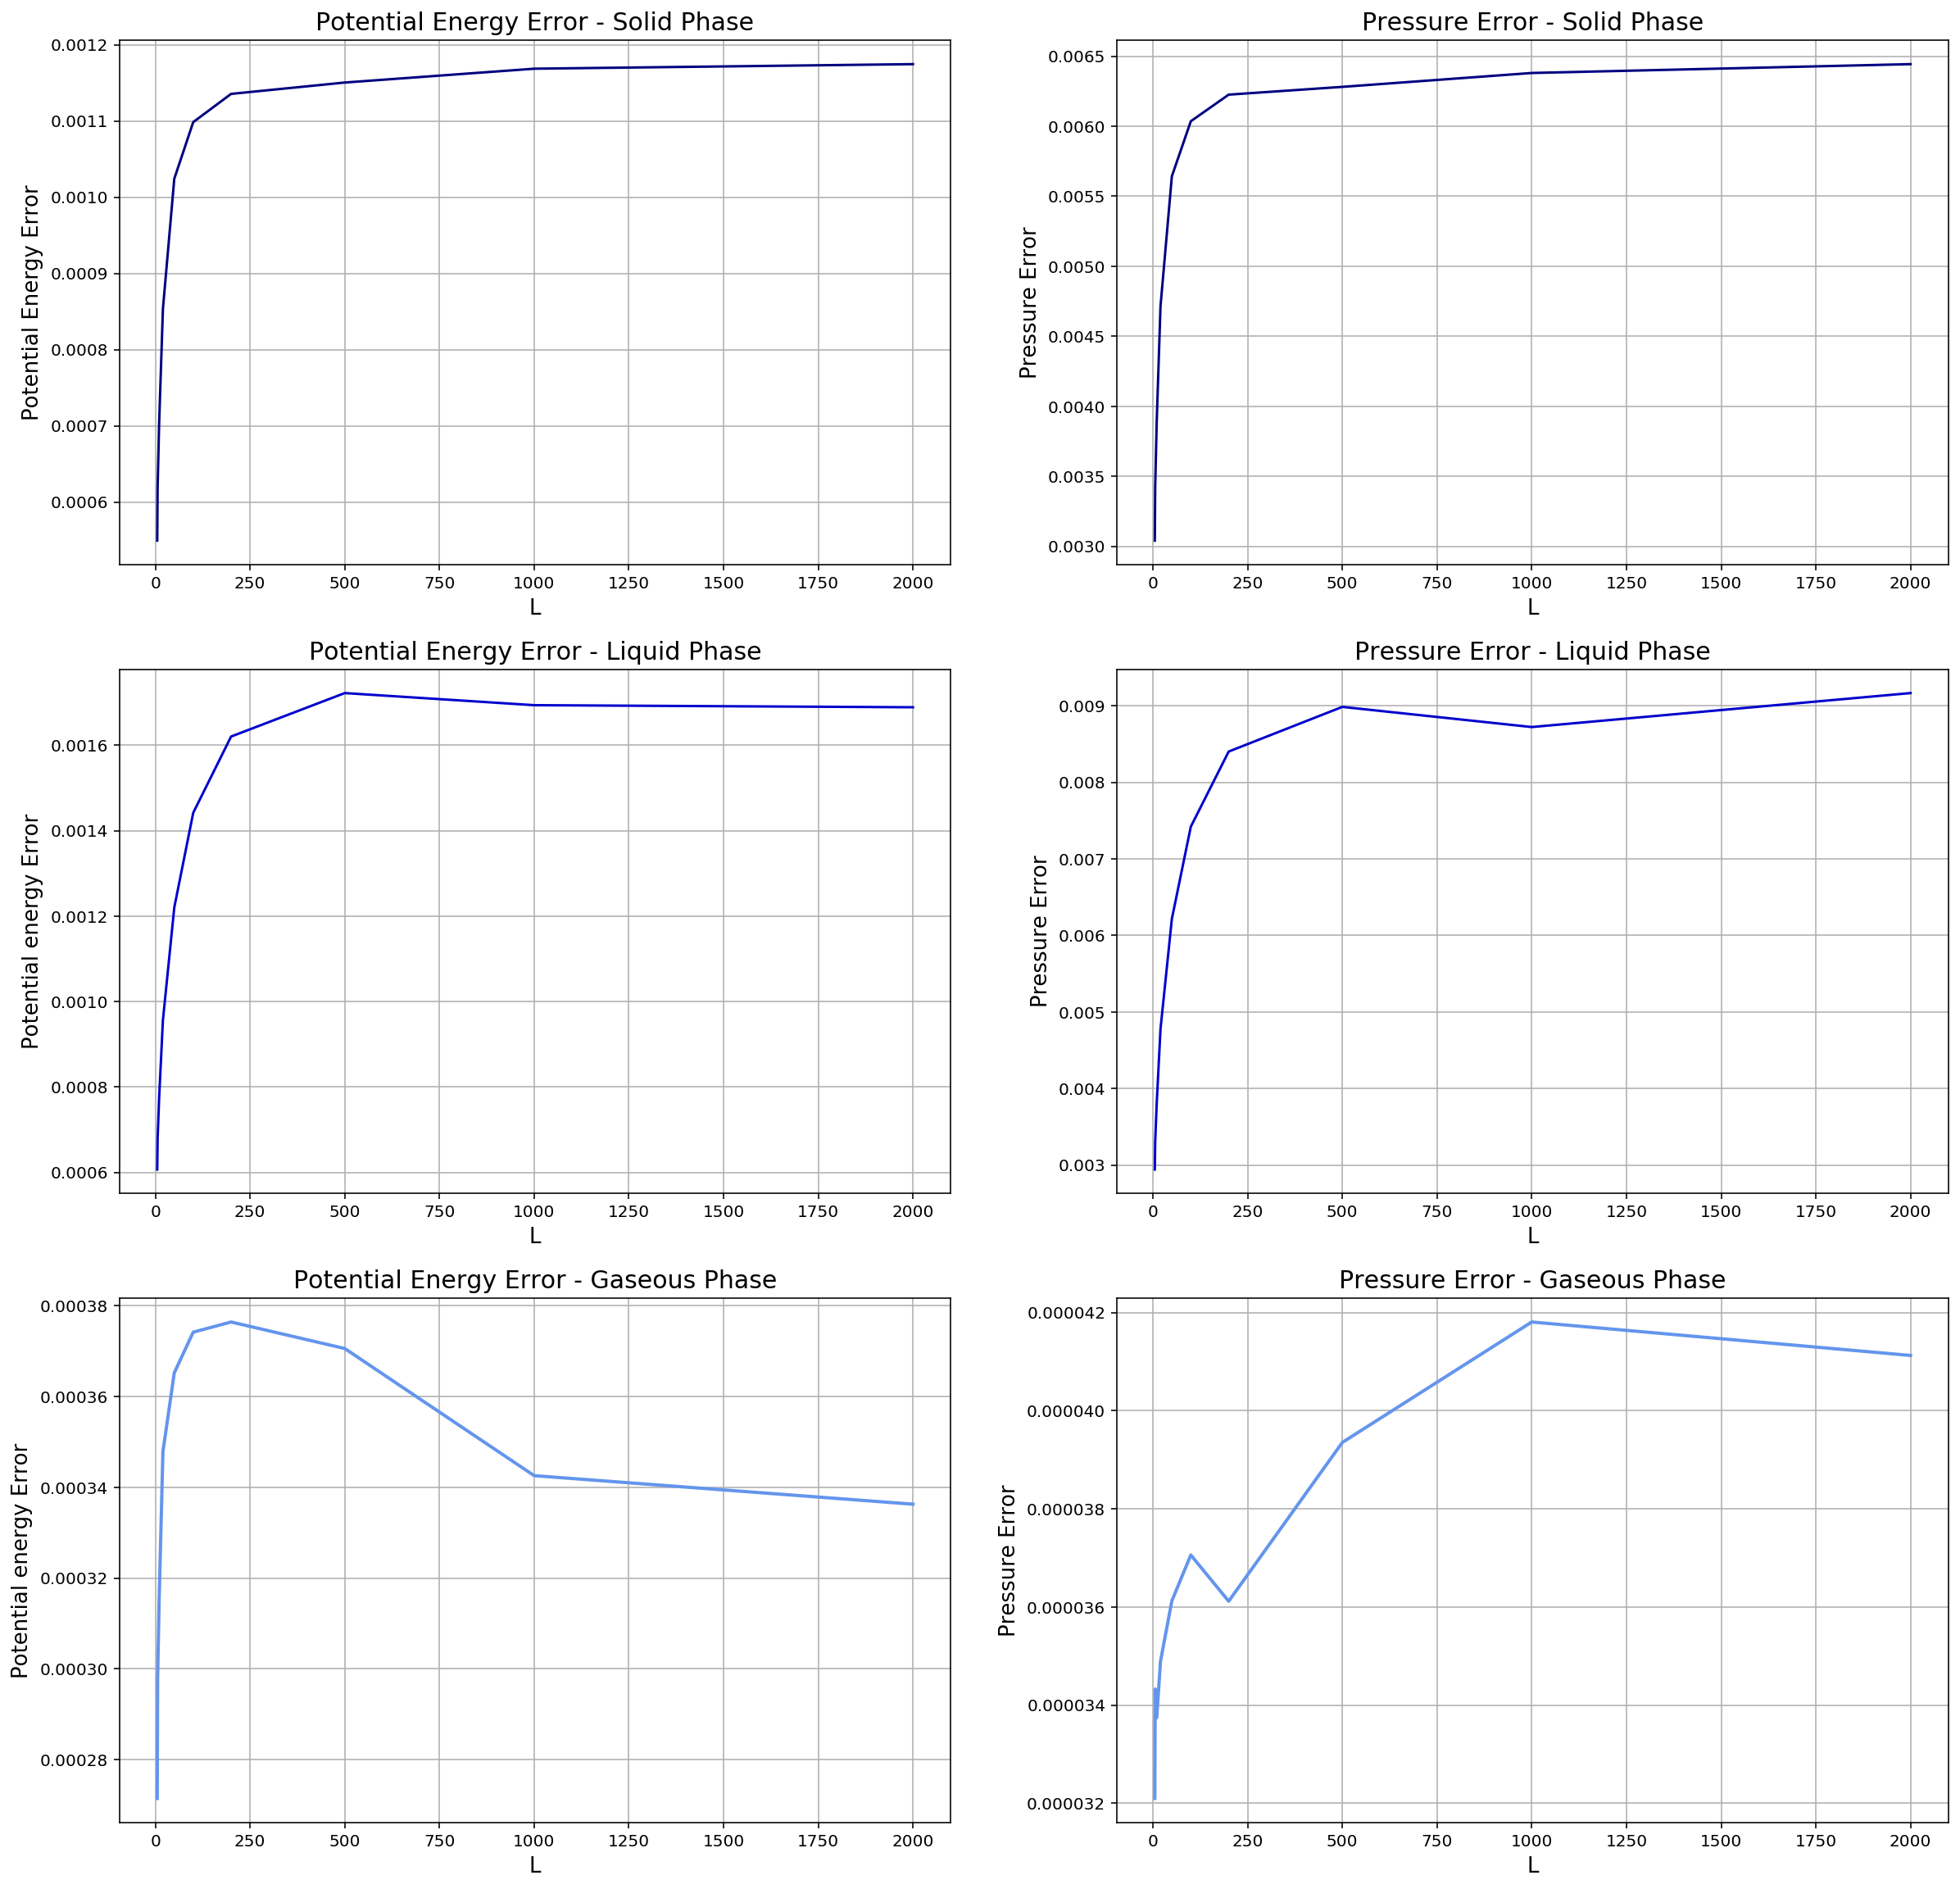

In [7]:
## Ora faccio i grafici degli errori in funzione della lunghezza dei blocchi ##
    
fig, axs = plt.subplots(3, 2, figsize=(20,20))

axs[0,0].plot(L, err_pot_s, color='navy')
axs[0,0].set_ylabel('Potential Energy Error', fontsize=13)
axs[0,0].set_title('Potential Energy Error - Solid Phase', fontsize=15)

axs[0,1].plot(L, err_pres_s, color='navy')
axs[0,1].set_ylabel('Pressure Error', fontsize=13)
axs[0,1].set_title('Pressure Error - Solid Phase', fontsize=15)

axs[1,0].plot(L, err_pot_l, color='mediumblue')
axs[1,0].set_ylabel('Potential energy Error', fontsize=13)
axs[1,0].set_title('Potential Energy Error - Liquid Phase', fontsize=15)

axs[1,1].plot(L, err_pres_l, color='mediumblue')
axs[1,1].set_ylabel('Pressure Error', fontsize=13)
axs[1,1].set_title('Pressure Error - Liquid Phase', fontsize=15)

axs[2,0].plot(L, err_pot_g, color='cornflowerblue', linewidth=2)
axs[2,0].set_ylabel('Potential energy Error', fontsize=13)
axs[2,0].set_title('Potential Energy Error - Gaseous Phase', fontsize=15)

axs[2,1].plot(L, err_pres_g, color='cornflowerblue', linewidth=2)
axs[2,1].set_ylabel('Pressure Error', fontsize=13)
axs[2,1].set_title('Pressure Error - Gaseous Phase', fontsize=15)

for ax in axs.flat:
    ax.set_xlabel('L', fontsize=13)
    ax.grid()


    

Si osserva che l'errore nei blocchi satura per $L\simeq 500$. Nelle simulazioni successive verranno quindi usati 200 blocchi con $L=500$ ciascuno in modo da avere blocchi sufficientemente grandi da far saturare l'errore e garantire una non-correlazione accettabile.

## Esercizi 7.2 e 7.3

<span style="color:red">Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the Monte Carlo NVT code</span> we have provided: average value of $g(r)$ in each block (with output in the file: output.gofr.0), final average value of $g(r)$ with statistical uncertainties (with output in the file: output.gave.0). <br/>
<span style="color:red">Include the calculation of the radial distribution function, $g(r)$, inside the previously used Molecular Dynamics code</span>.

Nel codice è stata implementata una funzione che mappa la funzione di distribuzione radiale a coppie. Per fare questo si è diviso l'intervallo $[0,L/2]$ in 100 bins e si è andato a riempire un istogramma con le distanze reciproche tra particelle. Il processo di riempimento dell'istogramma è semplice: si cicla su tutte le coppie di particelle, e se esse si trovano ad una distanza $r^*$ allora la frequenza del bin con $r_i < r^* < r_{i+1}$ viene aumentata di 2 unità. Alla fine del processo di riempimento si normalizza l'istogramma con la quantità $\rho N_{part} \Delta V(r)$ dove $\Delta V(r) = \frac{4\pi}{3} \left[ (r+dr)^3 - r^3\right]$. <br/>
Dopo aver testato la correttezza del mio codice, ho implementato la stessa funzione per il caso della dinamica molecolare, per poi eseguire un confronto nelle due diverse casisitiche.

## Esercizio 7.4

By means of your upgraded MC code, equilibrate and <span style="color:red">perform MC NVT simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

<span style="color:red">show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in SI units ... and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.</span>

Ho eseguito delle simulazioni con i parametri forniti in tutte e tre le fasi di Argon. Prima di passare alla fase di raccolta dati è stata eseguita l'equilibrazione salvando in output la configurazione finale raggiunta ma eliminando tutti i risultati fisici, ritenuti invalidi poiché ricavati da una situazione di non equilibrio. 
Ho convertito tutti i risultati in unità SI e ho plottato i grafici dei valori medi di energia potenziale e pressione in funzione del numero di blocchi. Come atteso, all'aumentare dei blocchi i valori vanno a convergenza e l'errore tende a ridursi. Un risultato altrettanto atteso è il decrescere dell'energia e della pressione nel transire da uno stato solido verso uno stato gassoso: il sistema volge infatti verso uno stato non legato, con la conseguente diminuzione di queste quantità. <br/>
Le $g(r)$ calcolate nei due metodi (dinamica molecolare e Metropolis) sono in ottimo accordo l'una con l'altra per tutte e tre le fasi; questo mi fa trarre due importanti conclusioni:
- Nel limite termodinamico (ovvefro quello di alta temperatura), l'ensemble canonico e microcanonico vanno a convergere mostrando gli stessi comportamenti
- La potenza di una simulazione Monte Carlo è sorprendente: infatti estraendo numeri casuali con l'algoritmo di Metropolis simulo un sistema statistico in modo persino migliore della dinamica molecolare, che va a integrare le equazioni del moto e segue ogni particella nella sua evoluzione deterministica.

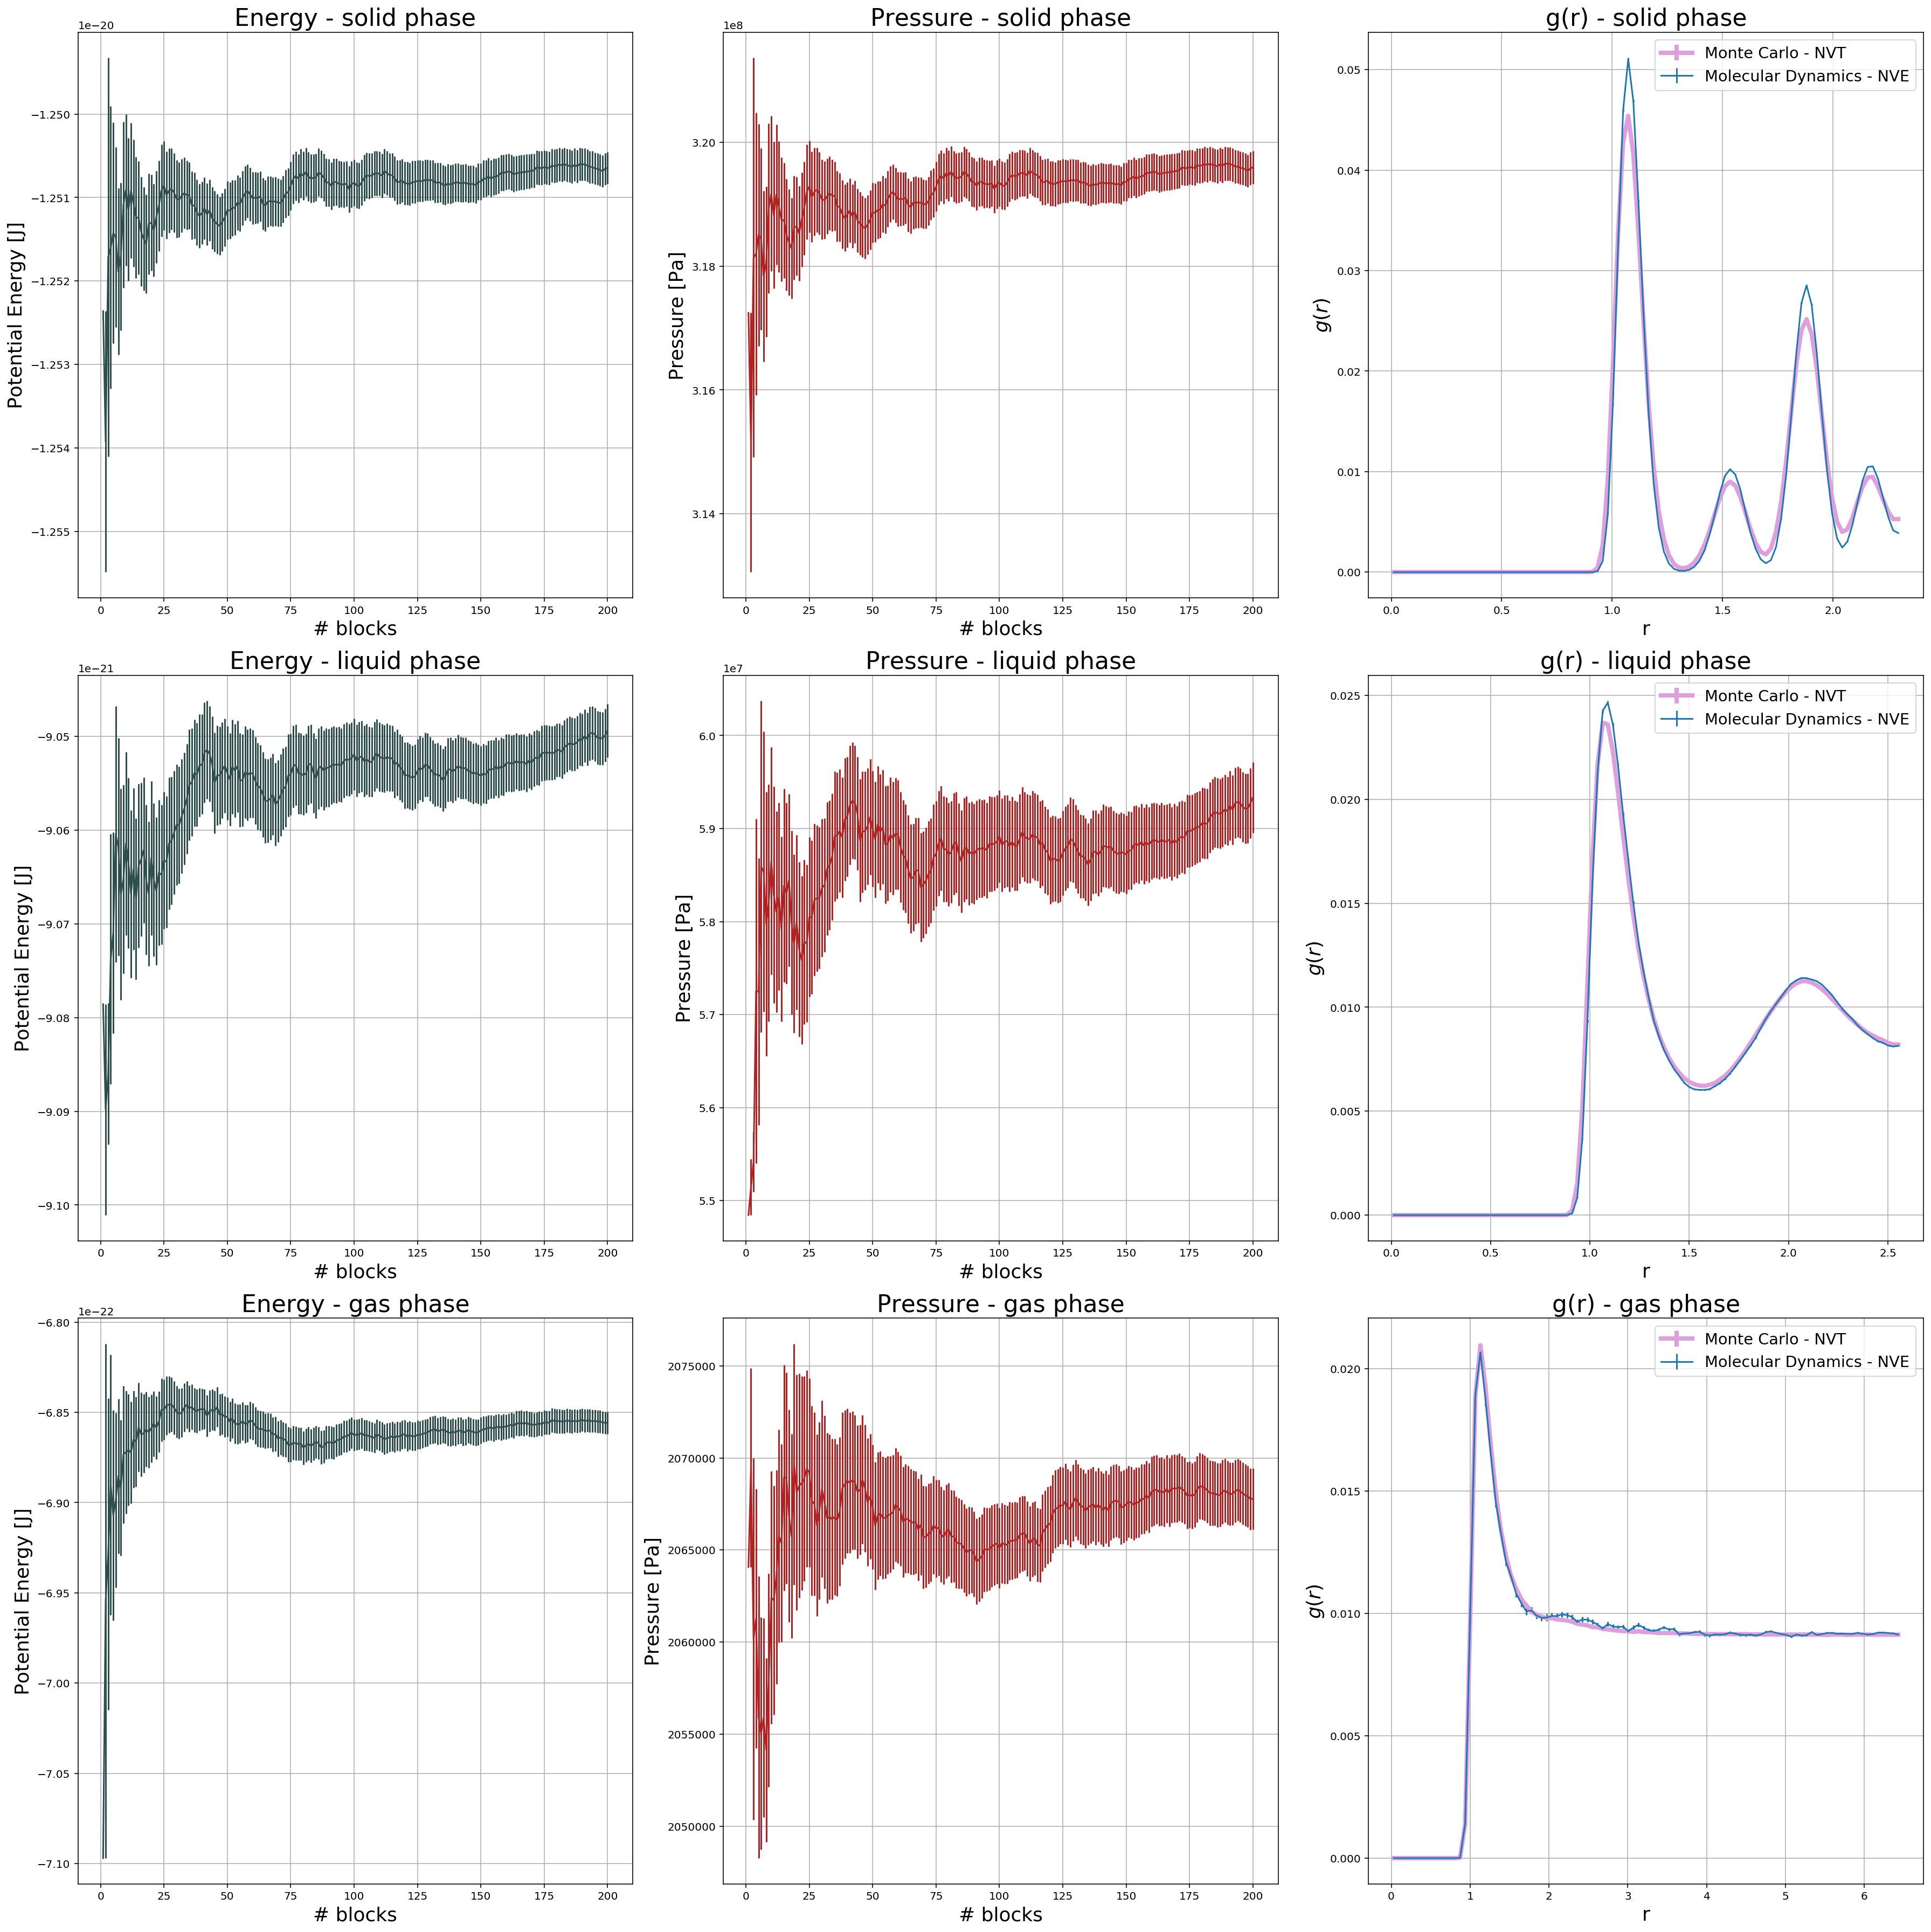

In [8]:
epsilon_kB = 120. #kelvin
kb = 1.380649*(10.**(-23))
epsilon = epsilon_kB*kb

sigma = 0.34*(10**(-9))
fatt_pres = epsilon/(sigma**3)

fig, axs = plt.subplots(3, 3, figsize=(25,25))

for index, phase in enumerate (phases):

    (blk, Epot, errEpot) = np.loadtxt(phase + '/' + phase +'_output.epot.0', unpack=True, usecols=(0, 2, 3))
    Epot = Epot*epsilon #SI Units!
    errEpot = errEpot*epsilon #SI Units!

    (blk, Pres, errPres) = np.loadtxt(phase + '/' + phase +'_output.pres.0', unpack=True, usecols=(0, 2, 3))
    Pres = Pres*fatt_pres #SI Units!
    errPres = errPres*fatt_pres #SI Units!

    (r, gdir, errGdir) = np.loadtxt( phase + '/' + phase +'_output.gave.0', unpack=True, usecols=(1, 2, 3))
    (r_MD, gdir_MD, errGdir_MD) = np.loadtxt('../Ex04_AS/' + phase + '/' + phase + '_output.gave.0', unpack=True, usecols=(1, 2, 3))


    axs[index,0].errorbar(blk, Epot, yerr=errEpot, color='darkslategrey')
    axs[index,0].set_ylabel('Potential Energy [J]', fontsize=18)
    axs[index,0].set_xlabel('# blocks', fontsize=18)
    axs[index,0].set_title('Energy - ' + phase + ' phase', fontsize=22)
    
    axs[index,1].errorbar(blk, Pres, yerr=errPres, color='firebrick')
    axs[index,1].set_ylabel('Pressure [Pa]', fontsize=18)
    axs[index,1].set_xlabel('# blocks', fontsize=18)
    axs[index,1].set_title('Pressure - ' + phase + ' phase', fontsize=22)
    
    axs[index,2].errorbar(r, gdir, yerr=errGdir, label = 'Monte Carlo - NVT', color='plum', linewidth=4)
    axs[index,2].errorbar(r_MD, gdir_MD, yerr=errGdir_MD, label = 'Molecular Dynamics - NVE')
    axs[index,2].set_xlabel('r', fontsize=18)
    axs[index,2].set_ylabel('$g(r)$', fontsize=18)
    axs[index,2].set_title('g(r) - ' + phase + ' phase', fontsize=22)
    axs[index,2].legend(fontsize='x-large')
    
for ax in axs.flat:
    ax.grid()
    
fig.tight_layout()
   